# とりあえずNNを回す

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import polars as pl
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import mlflow
import mlflow.pytorch

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import preprocess_for_all_models as my_preprocess
import preprocess_for_nn as my_nn_preprocess

## 各種定数

In [4]:
RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
TARGET_COLUMN = "ProdTaken"
DROP_COLUMNS = ["id", "MonthlyIncome", "customer_info"]

## 前処理

In [5]:
# ローカルファイルを読み込む
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
# google colaboratory で実行する場合は以下を有効にする
# from google.colab import drive
# drive.mount('/content/drive')
# train_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/train.csv")
# test_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/test.csv")

In [6]:
train_df, test_df = my_nn_preprocess.preprocess_data(train_df, test_df)

In [7]:
train_df.to_csv("../data/train_nn.csv", index=False)
test_df.to_csv("../data/test_nn.csv", index=False)

In [8]:
train_df.head()

,id,CityTier,DurationOfPitch,Occupation,Gender(is_male),NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,...,MonthlyIncome_numeric,car,children,TypeofContact_Company Invited,TypeofContact_Self Enquiry,TypeofContact_unknown,marriage_history_未婚,marriage_history_独身,marriage_history_結婚済み,marriage_history_離婚済み
0,0.0,0.5,0.416937,1.0,1.0,0.0,0.666667,0.00,0.0,0.625,...,0.134762,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.389172,0.0,1.0,0.0,0.666667,0.25,0.0,0.250,...,0.511187,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.0,0.0,0.278112,1.0,0.0,0.0,0.500000,0.00,0.0,0.500,...,0.195362,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,3.0,0.5,0.500231,0.5,0.0,0.0,0.500000,0.25,0.5,0.125,...,0.317012,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4.0,1.0,0.472466,0.5,0.0,0.0,0.500000,0.00,0.5,0.500,...,0.146087,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## 学習用データの設定

In [9]:
X_train = train_df.drop(columns=[TARGET_COLUMN, "id"])  # 入力データ
y_train = train_df[TARGET_COLUMN]  # ターゲット変数

In [10]:
X_train.loc[X_train["children"] == -1]

,CityTier,DurationOfPitch,Occupation,Gender(is_male),NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,...,MonthlyIncome_numeric,car,children,TypeofContact_Company Invited,TypeofContact_Self Enquiry,TypeofContact_unknown,marriage_history_未婚,marriage_history_独身,marriage_history_結婚済み,marriage_history_離婚済み
136,0.5,0.250347,1.0,0.0,0.333333,0.500000,0.75,0.5,0.250,0.0,...,0.709638,1.0,-1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
153,0.0,1.000000,0.5,1.0,0.666667,0.666667,0.75,0.0,0.375,0.0,...,0.725000,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
174,0.0,0.666821,0.5,1.0,0.333333,0.500000,0.75,0.0,0.875,0.0,...,0.570063,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
243,0.0,0.194817,0.0,1.0,0.333333,0.666667,0.75,0.5,0.750,0.0,...,0.900000,0.0,-1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
350,0.0,0.278112,1.0,0.0,0.333333,0.666667,0.75,0.5,0.125,0.0,...,0.776200,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
355,0.5,0.222582,0.0,1.0,0.666667,0.666667,1.00,0.0,0.375,0.0,...,0.738925,1.0,-1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
374,0.0,0.222582,0.0,0.0,0.666667,0.500000,0.75,0.0,0.500,0.0,...,0.747175,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
440,0.5,0.472466,0.0,0.0,0.666667,0.833333,0.75,0.0,0.625,0.0,...,0.605313,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
457,0.0,0.416937,0.5,1.0,0.333333,0.500000,1.00,0.0,0.625,0.0,...,0.759175,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
475,0.0,0.278112,1.0,1.0,1.000000,0.833333,1.00,0.0,0.375,0.0,...,0.660400,1.0,-1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# 検証用データの作成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

### データローダの設定

In [12]:
# PyTorch用のデータセットを作成
class TrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# データセットの作成
train_dataset = TrainDataset(X_train, y_train)
val_dataset = TrainDataset(X_val, y_val)

# データローダーの作成
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [13]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# モデルのインスタンス化
model = SimpleNN(input_dim=X_train.shape[1])


In [14]:
criterion = nn.BCELoss()  # バイナリクロスエントロピー損失
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
# Early Stoppingのパラメータ
early_stopping_patience = 10  # 悪化が連続する回数
best_val_loss = float('inf')
patience_counter = 0

# モデル保存用のパス
best_model_path = "../models/toy_best_model.pth"

# 訓練と検証の損失を格納するリスト
train_losses = []
val_losses = []
train_aucs = []

# 学習ループ
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_outputs = []
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # AUC計算のためにターゲットと出力を記録
        all_targets.extend(targets.cpu().numpy())
        all_outputs.extend(outputs.squeeze().detach().cpu().numpy())

    train_losses.append(running_loss / len(train_loader))

    # AUCを計算
    auc = roc_auc_score(all_targets, all_outputs)
    train_aucs.append(auc)

    # 検証フェーズ
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, AUC: {auc}')

    # Early Stoppingのチェックとモデル保存
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0  # 改善があったのでリセット
        torch.save(model.state_dict(), best_model_path)  # 最善のモデルを保存
    else:
        patience_counter += 1  # 改善がないのでカウントアップ

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        model.load_state_dict(torch.load(best_model_path))  # 最善のモデルをロード
        break

Epoch 1/100, Training Loss: 0.5715117495168339, Validation Loss: 0.3863582827828147, AUC: 0.5121727545930539
Epoch 2/100, Training Loss: 0.3969679948958484, Validation Loss: 0.3599809841676192, AUC: 0.6636645289215231
Epoch 3/100, Training Loss: 0.36702463538809255, Validation Loss: 0.3311914178458127, AUC: 0.7583289442430626
Epoch 4/100, Training Loss: 0.34466972811655566, Validation Loss: 0.3069099404595115, AUC: 0.7867604382893907
Epoch 5/100, Training Loss: 0.3297189629890702, Validation Loss: 0.298481746153398, AUC: 0.8027129741508401
Epoch 6/100, Training Loss: 0.3240205835212361, Validation Loss: 0.2932219898158854, AUC: 0.8074459625533145
Epoch 7/100, Training Loss: 0.3235068493946032, Validation Loss: 0.2910810261964798, AUC: 0.8097582385806198
Epoch 8/100, Training Loss: 0.319906183603135, Validation Loss: 0.2938217358155684, AUC: 0.8137115180055974
Epoch 9/100, Training Loss: 0.3192224089394916, Validation Loss: 0.29070228202776477, AUC: 0.8188503681672191
Epoch 10/100, Trai

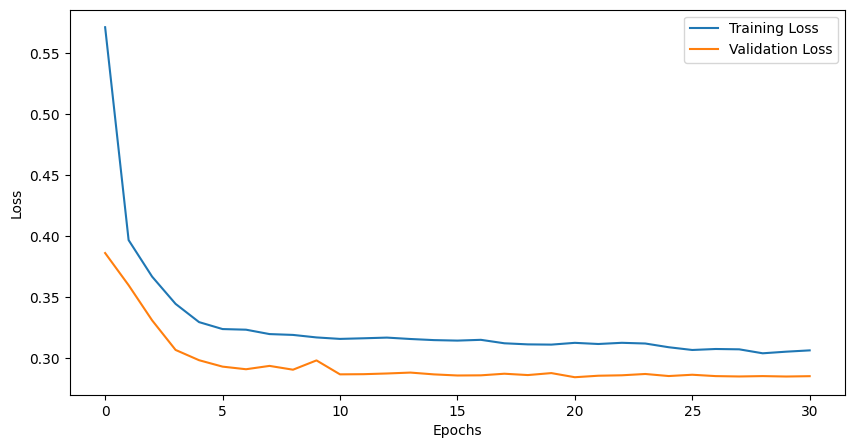

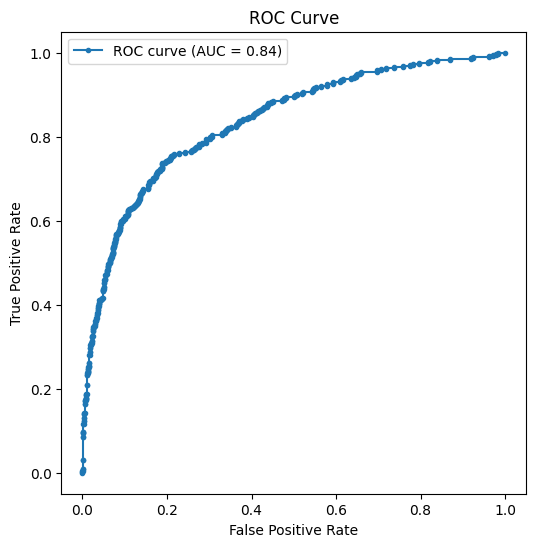

In [16]:
# 損失のグラフ化
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ROC曲線の描画
fpr, tpr, _ = roc_curve(all_targets, all_outputs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, marker='.', label=f'ROC curve (AUC = {auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [17]:
test_df.head()

,id,CityTier,DurationOfPitch,Occupation,Gender(is_male),NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,...,MonthlyIncome_numeric,car,children,TypeofContact_Company Invited,TypeofContact_Self Enquiry,TypeofContact_unknown,marriage_history_未婚,marriage_history_独身,marriage_history_結婚済み,marriage_history_離婚済み
0,3489.0,0.5,0.361407,0.5,1.0,0.0,0.666667,0.75,0.0,0.875,...,0.742375,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,3490.0,0.5,0.333642,0.5,0.0,0.0,0.666667,0.25,0.0,0.500,...,0.250000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3491.0,0.0,0.250347,0.0,0.0,0.0,0.666667,0.00,0.0,0.125,...,0.150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3492.0,0.5,0.194817,0.0,1.0,0.0,0.666667,0.00,0.5,0.125,...,0.149687,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3493.0,0.0,0.194817,0.0,1.0,0.0,0.666667,0.00,0.0,0.125,...,0.172075,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [20]:
# 特徴量として使用するカラムを定義 (NUMERIC_COLUMNSに基づく)
X_test = test_df.drop(columns=['id'])  # 'id' カラムを除外して特徴量に

# モデルのインスタンス化と最善モデルの読み込み
model = SimpleNN(input_dim=X_test.shape[1])
model.load_state_dict(torch.load("../models/toy_best_model.pth"))
model.eval()

# テストデータに対して予測を行う
with torch.no_grad():
    test_predictions = model(torch.tensor(X_test.values, dtype=torch.float32))
    test_predictions = test_predictions.squeeze().numpy()

# 結果をデータフレームに変換
submission_df = pd.DataFrame({
    'id': test_df['id'].astype(int),  # 'id' カラムを使用
    'prediction': test_predictions
})

# CSVファイルに保存
submission_df.to_csv('../data/submission_20240811.csv', index=False, header=None)